<a href="https://colab.research.google.com/github/Sabir123556/Batch22_1506/blob/main/projects_final1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
"""
Car Price Prediction - Regression + Classification (binned price)
Loads: /mnt/data/a52be7b2-b050-473c-b69e-56bd3e3f992d.csv

Outputs:
 - Regression metrics for multiple regressors
 - Classification reports (precision/recall/f1) after binning price into categories
"""

import re
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer, LabelEncoder

# Regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix

# ---------- Utilities to parse messy columns ----------
def extract_first_number(s):
    """Extract first float/integer from a string, return np.nan if none"""
    if pd.isnull(s):
        return np.nan
    s = str(s)
    m = re.search(r'[\d]+(?:\.\d+)?', s.replace(',', ''))
    return float(m.group()) if m else np.nan

def parse_engine_capacity(val):
    """Handle values like '1998 cc', '2.0L', '75 kWh' -> numeric (we'll keep kWh as numeric too)"""
    if pd.isnull(val):
        return np.nan
    s = str(val).lower()
    # if contains 'kwh' treat as numeric battery size
    if 'kwh' in s:
        return extract_first_number(s)  # battery size in kWh
    # liters -> convert to cc if necessary
    if 'l' in s and not 'cc' in s:
        n = extract_first_number(s)
        # if value < 30 assume liters
        if n is not None and n < 30:
            return n * 1000.0  # liters -> cc
    # default: extract number (often in cc)
    return extract_first_number(s)

def parse_horsepower(val):
    """Extract horsepower numeric (hp)"""
    return extract_first_number(val)

def parse_torque(val):
    """Extract torque numeric (assumes Nm)"""
    return extract_first_number(val)

def parse_top_speed(val):
    """Extract top speed numeric (km/h)"""
    return extract_first_number(val)

def parse_acceleration(val):
    """Extract 0-100 km/h seconds (numeric)"""
    return extract_first_number(val)

def find_price_col(df):
    """Attempt to find price column by name containing 'price' or '₹' or 'inr' etc."""
    for c in df.columns:
        if 'price' in c.lower() or '₹' in c or 'inr' in c.lower() or 'rs' in c.lower():
            return c
    # fallback: last column
    return df.columns[-1]

# ---------- Load dataset ----------
csv_path = "/content/Cars Datasets 2025.csv"
df = pd.read_csv(csv_path, encoding='latin-1')

print("Dataset loaded. Shape:", df.shape)
print("Columns:", list(df.columns))

# ---------- Normalize column names (helpful) ----------
df.columns = [c.strip() for c in df.columns]

# Find likely column names (flexible)
price_col = find_price_col(df)
print("Detected price column:", price_col)

# Example possible column name patterns
# company name, car name, engine type/config, engine capacity, horsepower, torque, top speed, acceleration, fuel type, seating capacity
# We'll attempt to map automatically where possible:
col_map = {}
cols_lower = {c.lower(): c for c in df.columns}

def find_col_by_keywords(keywords):
    keys = keywords if isinstance(keywords, list) else [keywords]
    for k in keys:
        for col_lower, orig in cols_lower.items():
            if k in col_lower:
                return orig
    return None

col_map['company'] = find_col_by_keywords(['company', 'maker', 'manufacturer', 'brand'])
col_map['car_name'] = find_col_by_keywords(['car name', 'model', 'car'])
col_map['engine_type'] = find_col_by_keywords(['engine type', 'engine config', 'configuration', 'engine'])
col_map['capacity'] = find_col_by_keywords(['capacity', 'cc', 'kwh', 'battery', 'displacement'])
col_map['horsepower'] = find_col_by_keywords(['horsepower', 'hp', 'bhp'])
col_map['torque'] = find_col_by_keywords(['torque', 'nm'])
col_map['top_speed'] = find_col_by_keywords(['top speed', 'top_speed', 'topspeed', 'km/h', 'kmh'])
col_map['acceleration'] = find_col_by_keywords(['0-100', '0–100', '0 to 100', 'acceleration', '0-60', '0–60'])
col_map['fuel_type'] = find_col_by_keywords(['fuel', 'fuel type', 'fuel_type'])
col_map['seating'] = find_col_by_keywords(['seat', 'seating', 'capacity'])

# Print mapping for user awareness
print("\nAuto-detected column mapping:")
for k, v in col_map.items():
    print(f"  {k}: {v}")

# ---------- Create working dataframe with selected columns ----------
# Keep company, engine_type, capacity, horsepower, torque, top_speed, acceleration, fuel_type, seating, price
working_cols = []
for key in ['company', 'engine_type', 'capacity', 'horsepower', 'torque', 'top_speed', 'acceleration', 'fuel_type', 'seating', 'car_name']:
    if col_map.get(key):
        working_cols.append(col_map[key])
# ensure price included
if price_col not in working_cols:
    working_cols.append(price_col)

# If nothing detected, use all columns as fallback
if len(working_cols) < 3:
    print("Few columns auto-detected. Using all original columns as fallback.")
    working_df = df.copy()
else:
    working_df = df[working_cols].copy()

# Rename columns to friendly names
rename_map = {}
for key in ['company','car_name','engine_type','capacity','horsepower','torque','top_speed','acceleration','fuel_type','seating']:
    if col_map.get(key):
        rename_map[col_map[key]] = key
rename_map[price_col] = 'price'
working_df = working_df.rename(columns=rename_map)
print("\nWorking dataframe columns after rename:", working_df.columns.tolist())

# ---------- Feature parsing ----------
# Parse numeric fields
if 'capacity' in working_df.columns:
    working_df['capacity_num'] = working_df['capacity'].apply(parse_engine_capacity)
else:
    working_df['capacity_num'] = np.nan

if 'horsepower' in working_df.columns:
    working_df['hp_num'] = working_df['horsepower'].apply(parse_horsepower)
else:
    working_df['hp_num'] = np.nan

if 'torque' in working_df.columns:
    working_df['torque_num'] = working_df['torque'].apply(parse_torque)
else:
    working_df['torque_num'] = np.nan

if 'top_speed' in working_df.columns:
    working_df['topspeed_num'] = working_df['top_speed'].apply(parse_top_speed)
else:
    working_df['topspeed_num'] = np.nan

if 'acceleration' in working_df.columns:
    working_df['accel_num'] = working_df['acceleration'].apply(parse_acceleration)
else:
    working_df['accel_num'] = np.nan

# seating numeric
if 'seating' in working_df.columns:
    working_df['seating_num'] = working_df['seating'].apply(extract_first_number)
else:
    working_df['seating_num'] = np.nan

# Price: extract numeric (if ranges like '20-25L' or '₹ 20,00,000' handle heuristically)
def parse_price(val):
    if pd.isnull(val):
        return np.nan
    s = str(val).lower().replace(',', '').replace('inr', '').replace('rs.', '').replace('₹','').strip()
    # handle ranges like '20-25 lakh' or '20-25 lakh' or '20-25L'
    # try to extract numbers and multipliers
    nums = re.findall(r'[\d]+(?:\.\d+)?', s)
    if not nums:
        return np.nan
    nums = [float(x) for x in nums]
    # infer multiplier words
    multiplier = 1.0
    if 'lakh' in s or 'lac' in s or 'l' in s and 'k' not in s:
        # interpret as lakhs -> convert to rupees (but keeping numeric unit is fine)
        # We'll convert everything to a common currency unit: assume numbers are in lakhs or in thousands?
        # Simpler approach: if numbers < 100 and 'lakh' in s assume it's lakhs -> multiply by 100000
        if any(x < 100 for x in nums):
            multiplier = 100000.0
    if 'crore' in s:
        multiplier = 10000000.0
    if 'k' in s and 'km' not in s:
        multiplier = 1000.0
    # take average if range
    val = np.mean(nums) * multiplier
    return val

working_df['price_num'] = working_df['price'].apply(parse_price)

# If price is still NaN (maybe already numeric), attempt direct cast
if working_df['price_num'].isna().sum() > 0:
    try:
        working_df['price_num'] = working_df['price_num'].fillna(pd.to_numeric(working_df['price'], errors='coerce'))
    except Exception:
        pass

# Drop rows without price
before = working_df.shape[0]
working_df = working_df.dropna(subset=['price_num']).reset_index(drop=True)
after = working_df.shape[0]
print(f"\nDropped {before-after} rows without parsable price. Remaining: {after}")

# ---------- Select features for modeling ----------
# Choose categorical features: company, engine_type, fuel_type, maybe car_name (but can be high-cardinality)
cat_features = [c for c in ['company', 'engine_type', 'fuel_type', 'car_name'] if c in working_df.columns]
num_features = ['capacity_num', 'hp_num', 'torque_num', 'topspeed_num', 'accel_num', 'seating_num']

# Ensure numeric columns exist
num_features = [c for c in num_features if c in working_df.columns]

print("\nCategorical features:", cat_features)
print("Numeric features:", num_features)

# Create final feature DataFrame
X = working_df[cat_features + num_features].copy()
y_reg = working_df['price_num'].astype(float).copy()

# Simple stats
print("\nTarget price stats (num):")
print(y_reg.describe().apply(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x))

# ---------- Split data ----------
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)

# ---------- Preprocessing pipelines ----------
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features)
], remainder='drop')

# ---------- Regression models ----------
regressors = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.01, max_iter=5000),
    'SVR': SVR(kernel='rbf', C=1.0, gamma='scale'),
    'KNNRegressor': KNeighborsRegressor(n_neighbors=5),
    'DecisionTreeRegressor': DecisionTreeRegressor(max_depth=6, random_state=42),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=200, max_depth=12, random_state=42, n_jobs=-1),
    'GradientBoostingRegressor': GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
}

def eval_regressor(name, model, X_train, X_test, y_train, y_test):
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = mean_squared_error(y_test, preds, squared=False)
    r2 = r2_score(y_test, preds)
    print(f"\n{name} Results:")
    print(f"  MAE  : {mae:,.2f}")
    print(f"  RMSE : {rmse:,.2f}")
    print(f"  R^2  : {r2:.4f}")
    return pipe, preds

print("\n=== REGRESSION: Training and evaluating models ===")
regression_results = {}
for name, model in regressors.items():
    try:
        pipe, preds = eval_regressor(name, model, X_train, X_test, y_train_reg, y_test_reg)
        regression_results[name] = {'pipeline': pipe, 'preds': preds}
    except Exception as e:
        print(f"  ERROR training {name}: {e}")

# ---------- Classification: bin price into categories and run classifiers ----------
# We'll create price categories (e.g., 4 bins: Low / Mid / High / Luxury) using quantiles by default
n_bins = 4
# KBinsDiscretizer can create bins but we'll use quantiles manually for labeling clarity
bins = np.quantile(y_reg, np.linspace(0, 1, n_bins + 1))
# Ensure unique edges
bins = np.unique(bins)
print("\nPrice bin edges (numeric):", bins)

# Create category labels
labels = [f"Bin_{i+1}" for i in range(len(bins)-1)]
working_df['price_bin'] = pd.cut(working_df['price_num'], bins=bins, labels=labels, include_lowest=True)
print("\nPrice bin counts:")
print(working_df['price_bin'].value_counts())

# Use same X but align y_class with X rows (we already had X aligned earlier)
y_class_all = working_df['price_bin'].astype(str)
# Rebuild X_all to ensure alignment
X_all = working_df[cat_features + num_features].copy()

# Split for classification (stratify by bins to preserve distribution)
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_all, y_class_all, test_size=0.2, random_state=42, stratify=y_class_all)

# Define classifiers
classifiers = {
    'LogisticRegression': LogisticRegression(max_iter=2000),
    'DecisionTree': DecisionTreeClassifier(max_depth=8, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=200, max_depth=12, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42),
    'SVC': SVC(kernel='rbf', probability=True),
    'KNeighbors': KNeighborsClassifier(n_neighbors=5),
    'GaussianNB': GaussianNB()
}

def eval_classifier(name, clf, X_train, X_test, y_train, y_test):
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('clf', clf)])
    pipe.fit(X_train, y_train)
    ypred = pipe.predict(X_test)
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, ypred, digits=4))
    cm = confusion_matrix(y_test, ypred, labels=np.unique(y_test))
    print(f"Confusion Matrix (rows=truth, cols=pred) shape {cm.shape}")
    return pipe, ypred

print("\n=== CLASSIFICATION: Training and printing classification reports ===")
classification_results = {}
for name, clf in classifiers.items():
    try:
        pipe, ypred = eval_classifier(name, clf, Xc_train, Xc_test, yc_train, yc_test)
        classification_results[name] = {'pipeline': pipe, 'ypred': ypred}
    except Exception as e:
        print(f"  ERROR training {name}: {e}")

# ---------- Quick cross-validation summary (optional) ----------
print("\n=== OPTIONAL: 5-fold CV scores (R^2) for top regression models ===")
from sklearn.model_selection import cross_val_score
for name in ['RandomForestRegressor', 'GradientBoostingRegressor', 'Ridge']:
    if name in regression_results:
        model_pipeline = regression_results[name]['pipeline']
        scores = cross_val_score(model_pipeline, X, y_reg, cv=5, scoring='r2', n_jobs=-1)
        print(f"{name} CV R^2 mean: {scores.mean():.4f}, std: {scores.std():.4f}")

print("\nScript finished. You can extend this script to do hyperparameter tuning (GridSearchCV), feature importance plotting, or saving models with joblib.")

Dataset loaded. Shape: (1218, 11)
Columns: ['Company Names', 'Cars Names', 'Engines', 'CC/Battery Capacity', 'HorsePower', 'Total Speed', 'Performance(0 - 100 )KM/H', 'Cars Prices', 'Fuel Types', 'Seats', 'Torque']
Detected price column: Cars Names

Auto-detected column mapping:
  company: Company Names
  car_name: Cars Names
  engine_type: Engines
  capacity: CC/Battery Capacity
  horsepower: HorsePower
  torque: Torque
  top_speed: Performance(0 - 100 )KM/H
  acceleration: None
  fuel_type: Fuel Types
  seating: Seats

Working dataframe columns after rename: ['company', 'engine_type', 'capacity', 'horsepower', 'torque', 'top_speed', 'fuel_type', 'seating', 'price']

Dropped 793 rows without parsable price. Remaining: 425

Categorical features: ['company', 'engine_type', 'fuel_type']
Numeric features: ['capacity_num', 'hp_num', 'torque_num', 'topspeed_num', 'accel_num', 'seating_num']

Target price stats (num):
count         425.00
mean       622775.81
std       4212965.42
min        

Loaded dataset shape: (1218, 11)
Columns: ['Company Names', 'Cars Names', 'Engines', 'CC/Battery Capacity', 'HorsePower', 'Total Speed', 'Performance(0 - 100 )KM/H', 'Cars Prices', 'Fuel Types', 'Seats', 'Torque']

Auto-detected columns (best-effort):
 price: Cars Prices
 company: Company Names
 car name: Cars Names
 engine: Engines
 capacity: CC/Battery Capacity
 hp: HorsePower
 torque: Torque
 topspeed: Performance(0 - 100 )KM/H
 accel: None
 fuel: Fuel Types
 seating: Seats

Working frame columns: ['company', 'car_name', 'engine_type', 'capacity', 'horsepower', 'torque', 'top_speed', 'fuel_type', 'seating', 'price']

Preview parsed numeric columns:
   capacity_num  hp_num  torque_num  topspeed_num  accel_num  seating_num  \
0        3990.0   963.0       800.0           2.5        NaN          2.0   
1        6749.0   563.0       900.0           5.3        NaN          5.0   
2        1200.0    70.0       100.0          10.5        NaN          5.0   
3        3982.0   630.0       90

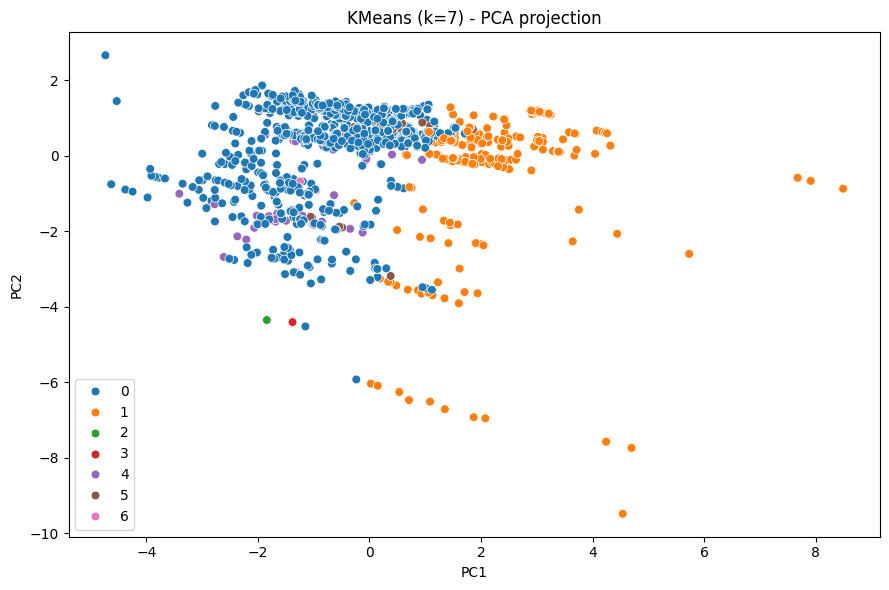


Computing t-SNE (this may take a while for large datasets)...


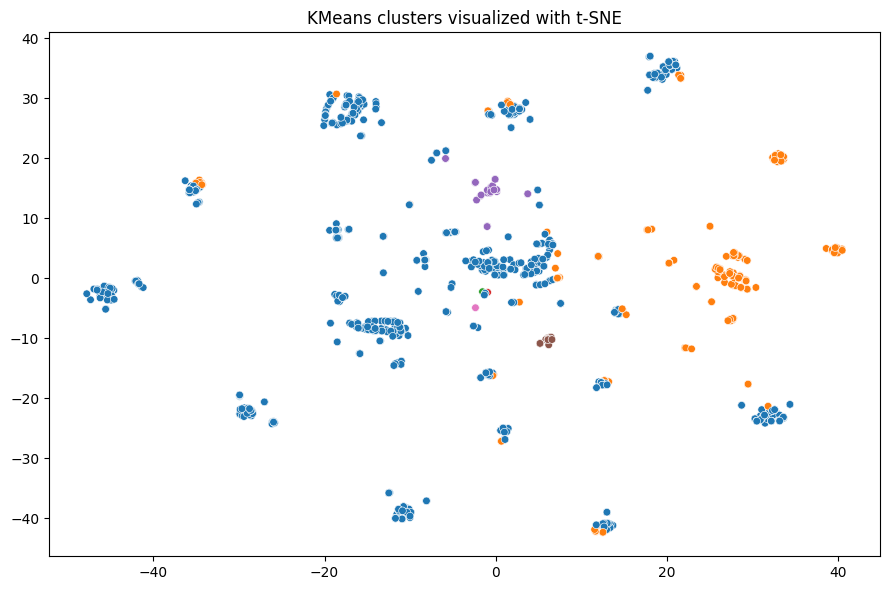

Computing UMAP visualization...


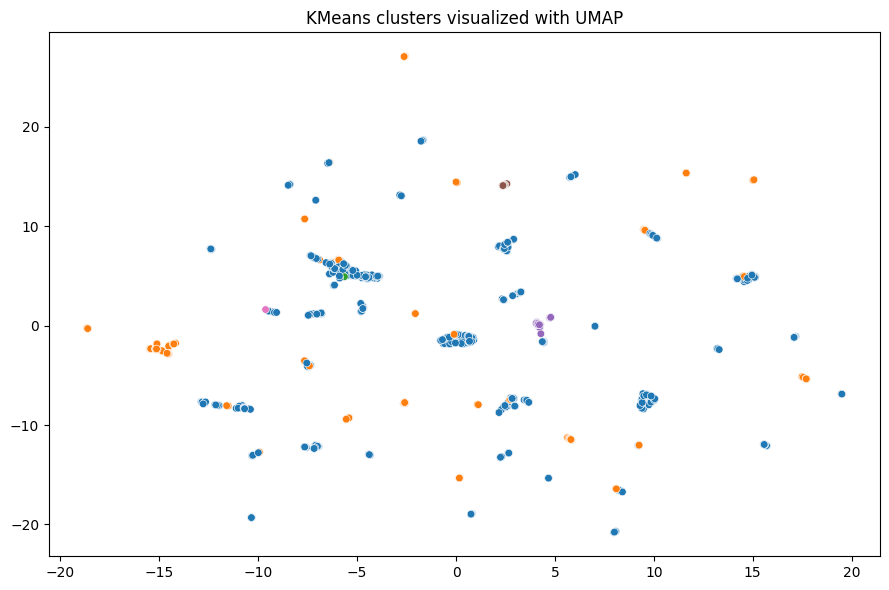


Saved cluster assignments to: /content/car_clustering_results.csv

Done. Next recommended steps:
 - Inspect `car_clustering_results.csv` for cluster assignments and compare with price or brand columns.
 - Tune DBSCAN/OPTICS eps/min_samples for better density-based clusters.
 - Use GridSearch on KMeans / GMM (vary n_components) and compare Silhouette / Calinski-Harabasz.
 - If you want interpretable clusters, reduce categorical one-hot explosion (e.g., group brands into segments).
 - Export cluster centroids (for KMeans) to understand typical car profiles per cluster.



In [30]:
"""
Unsupervised Learning Suite for Car Dataset
Loads:  /mnt/data/a52be7b2-b050-473c-b69e-56bd3e3f992d.csv

Implements:
 - preprocessing & parsing of messy columns
 - PCA, t-SNE, (UMAP optional)
 - KMeans (with helpers), Agglomerative, DBSCAN, OPTICS, MeanShift, Birch, SpectralClustering, GMM
 - IsolationForest for anomaly detection
 - cluster evaluation metrics and cluster profiling
"""

import re
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE

# Clustering & anomaly models
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS, MeanShift, Birch, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest

# Metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Optional: UMAP (if installed)
try:
    import umap
    _umap_available = True
except Exception:
    _umap_available = False

# -------------------- Helper parsing utilities --------------------
def extract_first_number(s):
    """Extract first float/integer from a string, return np.nan if none"""
    if pd.isnull(s):
        return np.nan
    s = str(s)
    m = re.search(r'[\d]+(?:\.\d+)?', s.replace(',', ''))
    return float(m.group()) if m else np.nan

def parse_engine_capacity(val):
    """Handle values like '1998 cc', '2.0L', '75 kWh' -> numeric (keep units consistent: cc for ICE, kWh for EV)"""
    if pd.isnull(val):
        return np.nan
    s = str(val).lower()
    if 'kwh' in s:
        return extract_first_number(s)  # battery size as-is (kWh)
    if 'l' in s and 'cc' not in s:
        n = extract_first_number(s)
        if n is not None and n < 30:  # treat as liters -> convert to cc
            return n * 1000.0
    return extract_first_number(s)

def parse_horsepower(val):
    return extract_first_number(val)

def parse_torque(val):
    return extract_first_number(val)

def parse_top_speed(val):
    return extract_first_number(val)

def parse_acceleration(val):
    return extract_first_number(val)

def parse_price(val):
    """Heuristic parser; outputs price as a numeric value (same base unit as the input implies).
       For example, '20-25 lakh' -> numeric rupee value (2,000,000) if 'lakh' found.
       If input is numeric string, returns numeric.
    """
    if pd.isnull(val):
        return np.nan
    s = str(val).lower().replace(',', '').replace('inr', '').replace('rs.', '').replace('₹','').strip()
    nums = re.findall(r'[\d]+(?:\.\d+)?', s)
    if not nums:
        return np.nan
    nums = [float(x) for x in nums]
    # multipliers
    multiplier = 1.0
    if 'lakh' in s or 'lac' in s:
        multiplier = 100000.0
    if 'crore' in s:
        multiplier = 10000000.0
    if 'k' in s and 'km' not in s:
        # ambiguous; only apply if numbers are reasonable
        multiplier = 1000.0
    val = np.mean(nums) * multiplier
    return val

# -------------------- Load dataset --------------------
CSV_PATH = "/content/Cars Datasets 2025.csv"
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV not found at {CSV_PATH}")

df = pd.read_csv(CSV_PATH, encoding='latin-1')
print("Loaded dataset shape:", df.shape)
print("Columns:", list(df.columns))

# Normalize column names
df.columns = [c.strip() for c in df.columns]

# Try to map common column names
cols_lower = {c.lower(): c for c in df.columns}

def find_col_by_keywords(keywords):
    for k in (keywords if isinstance(keywords, list) else [keywords]):
        for col_lower, orig in cols_lower.items():
            if k in col_lower:
                return orig
    return None

price_col = find_col_by_keywords(['price','₹','inr','rs','cost'])
company_col = find_col_by_keywords(['company','brand','maker','manufacturer'])
carname_col = find_col_by_keywords(['car name','model','car'])
engine_col = find_col_by_keywords(['engine','configuration','engine type'])
capacity_col = find_col_by_keywords(['capacity','cc','kwh','displacement','battery'])
hp_col = find_col_by_keywords(['horsepower','hp','bhp'])
torque_col = find_col_by_keywords(['torque','nm'])
topspeed_col = find_col_by_keywords(['top speed','topspeed','km/h','kmh'])
accel_col = find_col_by_keywords(['0-100','0â€“100','0 to 100','acceleration','0-60'])
fuel_col = find_col_by_keywords(['fuel','fuel type','fuel_type'])
seating_col = find_col_by_keywords(['seat','seating','capacity'])

print("\nAuto-detected columns (best-effort):")
print(" price:", price_col)
print(" company:", company_col)
print(" car name:", carname_col)
print(" engine:", engine_col)
print(" capacity:", capacity_col)
print(" hp:", hp_col)
print(" torque:", torque_col)
print(" topspeed:", topspeed_col)
print(" accel:", accel_col)
print(" fuel:", fuel_col)
print(" seating:", seating_col)

# Build working dataframe (keep original columns referenced)
working_cols = []
for c in [company_col, carname_col, engine_col, capacity_col, hp_col, torque_col, topspeed_col, accel_col, fuel_col, seating_col]:
    if c:
        working_cols.append(c)
if price_col and price_col not in working_cols:
    working_cols.append(price_col)

if len(working_cols) < 3:
    # fallback: use all columns
    print("Using all original columns as fallback.")
    working_df = df.copy()
else:
    working_df = df[working_cols].copy()

# Rename to friendly names when present
rename_map = {}
if company_col: rename_map[company_col] = 'company'
if carname_col: rename_map[carname_col] = 'car_name'
if engine_col: rename_map[engine_col] = 'engine_type'
if capacity_col: rename_map[capacity_col] = 'capacity'
if hp_col: rename_map[hp_col] = 'horsepower'
if torque_col: rename_map[torque_col] = 'torque'
if topspeed_col: rename_map[topspeed_col] = 'top_speed'
if accel_col: rename_map[accel_col] = 'acceleration'
if fuel_col: rename_map[fuel_col] = 'fuel_type'
if seating_col: rename_map[seating_col] = 'seating'
if price_col: rename_map[price_col] = 'price'
working_df = working_df.rename(columns=rename_map)
print("\nWorking frame columns:", working_df.columns.tolist())

# -------------------- Parse numeric features --------------------
# Create numeric columns from textual columns if available
if 'capacity' in working_df.columns:
    working_df['capacity_num'] = working_df['capacity'].apply(parse_engine_capacity)
else:
    working_df['capacity_num'] = np.nan

if 'horsepower' in working_df.columns:
    working_df['hp_num'] = working_df['horsepower'].apply(parse_horsepower)
else:
    working_df['hp_num'] = np.nan

if 'torque' in working_df.columns:
    working_df['torque_num'] = working_df['torque'].apply(parse_torque)
else:
    working_df['torque_num'] = np.nan

if 'top_speed' in working_df.columns:
    working_df['topspeed_num'] = working_df['top_speed'].apply(parse_top_speed)
else:
    working_df['topspeed_num'] = np.nan

if 'acceleration' in working_df.columns:
    working_df['accel_num'] = working_df['acceleration'].apply(parse_acceleration)
else:
    working_df['accel_num'] = np.nan

if 'seating' in working_df.columns:
    working_df['seating_num'] = working_df['seating'].apply(extract_first_number)
else:
    working_df['seating_num'] = np.nan

if 'price' in working_df.columns:
    working_df['price_num'] = working_df['price'].apply(parse_price)
else:
    working_df['price_num'] = np.nan

print("\nPreview parsed numeric columns:")
print(working_df[['capacity_num','hp_num','torque_num','topspeed_num','accel_num','seating_num','price_num']].head())

# Drop rows with extremely sparse information (optionally keep more—tweak threshold)
min_required_numeric = 1  # at least 1 numeric spec
num_cols = ['capacity_num','hp_num','torque_num','topspeed_num','accel_num','seating_num']
working_df['num_valid_specs'] = working_df[num_cols].notnull().sum(axis=1)
df_clean = working_df[working_df['num_valid_specs'] >= min_required_numeric].copy()
print(f"\nRows before cleaning: {len(working_df)}, after numeric filter: {len(df_clean)}")

# -------------------- Feature selection for unsupervised tasks --------------------
# Choose features to include in clustering. Two common options:
#  - specs_only: only technical numeric specs (no price)
#  - specs_plus_price: include price_num (if available)
specs_only = []
for c in ['capacity_num','hp_num','torque_num','topspeed_num','accel_num','seating_num']:
    if c in df_clean.columns and df_clean[c].notnull().sum() > 0:
        specs_only.append(c)

include_price = ('price_num' in df_clean.columns and df_clean['price_num'].notnull().sum() > 0)

# Build feature matrix
X_specs = df_clean[specs_only].copy()
X_specs_with_price = df_clean[specs_only + (['price_num'] if include_price else [])].copy()

print("\nFeature sets:")
print(" specs_only:", X_specs.shape)
print(" specs_plus_price:", X_specs_with_price.shape)

# Preprocessing pipeline: impute + scale
from sklearn.pipeline import make_pipeline
num_imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_specs_proc = pd.DataFrame(scaler.fit_transform(num_imputer.fit_transform(X_specs)),
                            index=X_specs.index, columns=X_specs.columns)

if include_price:
    X_specs_price_proc = pd.DataFrame(scaler.fit_transform(num_imputer.fit_transform(X_specs_with_price)),
                                     index=X_specs_with_price.index, columns=X_specs_with_price.columns)
else:
    X_specs_price_proc = X_specs_proc.copy()

# Optional: add categorical encoded features (company, fuel_type) — comment/uncomment if desired
cat_features = []
if 'company' in df_clean.columns:
    cat_features.append('company')
if 'fuel_type' in df_clean.columns:
    cat_features.append('fuel_type')

if cat_features:
    # One-hot encode and add to numeric matrix (can explode dims if many brands)
    oh = OneHotEncoder(handle_unknown='ignore')
    cat_mat = oh.fit_transform(df_clean[cat_features].fillna('missing'))
    cat_cols = [f"{f}__{v}" for f, vals in zip(cat_features, oh.categories_) for v in vals]
    cat_df = pd.DataFrame(cat_mat.toarray(), index=df_clean.index, columns=cat_cols) # Convert sparse to dense
    # Scale categorical (optional)
    cat_df = pd.DataFrame(scaler.fit_transform(cat_df), index=cat_df.index, columns=cat_df.columns)
    # Append to specs
    X_full = pd.concat([X_specs_proc, cat_df], axis=1)
    X_full_price = pd.concat([X_specs_price_proc, cat_df], axis=1)
else:
    X_full = X_specs_proc.copy()
    X_full_price = X_specs_price_proc.copy()

print("\nFinal feature matrices shapes:")
print(" X_full (no price):", X_full.shape)
print(" X_full_price (price included if available):", X_full_price.shape)

# -------------------- Dimensionality reduction helpers --------------------
def compute_pca(X, n_components=2):
    pca = PCA(n_components=n_components, random_state=42)
    pcs = pca.fit_transform(X)
    return pca, pcs

def compute_tsne(X, n_components=2, perplexity=30):
    tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=42, init='pca', learning_rate='auto')
    return tsne.fit_transform(X)

def compute_umap(X, n_components=2):
    if not _umap_available:
        raise RuntimeError("UMAP not installed (pip install umap-learn) to use this function.")
    reducer = umap.UMAP(n_components=n_components, random_state=42)
    return reducer.fit_transform(X)

# 2D PCA for plotting baseline
pca2, X_pca2 = compute_pca(X_full, n_components=2)

# -------------------- Cluster evaluation utility --------------------
def cluster_evaluation(X, labels, metric_names=True):
    # labels: array-like cluster labels (noise like -1 is allowed)
    unique_labels = np.unique(labels)
    n_clusters = len([l for l in unique_labels if l != -1])
    out = {'n_clusters': n_clusters}
    if n_clusters > 1 and len(X) > n_clusters:
        try:
            out['silhouette'] = silhouette_score(X, labels)
        except Exception:
            out['silhouette'] = np.nan
        try:
            out['calinski_harabasz'] = calinski_harabasz_score(X, labels)
        except Exception:
            out['calinski_harabasz'] = np.nan
        try:
            out['davies_bouldin'] = davies_bouldin_score(X, labels)
        except Exception:
            out['davies_bouldin'] = np.nan
    else:
        out['silhouette'] = np.nan
        out['calinski_harabasz'] = np.nan
        out['davies_bouldin'] = np.nan
    return out

# -------------------- Run many clustering algorithms --------------------
results = {}

# 1) KMeans: run for a range of k and compute silhouette to help choose k
k_range = list(range(2, 10))
print("\nRunning KMeans for k in", k_range)
km_scores = {}
for k in k_range:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X_full)
    evals = cluster_evaluation(X_full, labels)
    km_scores[k] = evals
    print(f" K={k}: clusters={evals['n_clusters']}, silhouette={evals['silhouette']}, calinski={evals['calinski_harabasz']}")

# Choose a default k (best silhouette if available)
best_k = max(km_scores.keys(), key=lambda kk: (km_scores[kk]['silhouette'] if km_scores[kk]['silhouette']==km_scores[kk]['silhouette'] else -999))
print("Recommended k (best silhouette):", best_k)
kmeans_final = KMeans(n_clusters=best_k, n_init=20, random_state=42).fit(X_full)
results['KMeans'] = {'model': kmeans_final, 'labels': kmeans_final.labels_, 'eval': cluster_evaluation(X_full, kmeans_final.labels_)}

# 2) Gaussian Mixture (GMM) - try several components
gmm_scores = {}
for k in k_range:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    labels = gmm.fit_predict(X_full)
    gmm_scores[k] = cluster_evaluation(X_full, labels)
    print(f"GMM k={k}: silhouette={gmm_scores[k]['silhouette']}")
best_k_gmm = max(gmm_scores.keys(), key=lambda kk: (gmm_scores[kk]['silhouette'] if gmm_scores[kk]['silhouette']==gmm_scores[kk]['silhouette'] else -999))
gmm_final = GaussianMixture(n_components=best_k_gmm, random_state=42).fit(X_full)
gmm_labels = gmm_final.predict(X_full)
results['GMM'] = {'model': gmm_final, 'labels': gmm_labels, 'eval': cluster_evaluation(X_full, gmm_labels)}

# 3) Agglomerative (hierarchical)
agg = AgglomerativeClustering(n_clusters=best_k, linkage='ward')
agg_labels = agg.fit_predict(X_full)
results['Agglomerative'] = {'model': agg, 'labels': agg_labels, 'eval': cluster_evaluation(X_full, agg_labels)}
print("Agglomerative silhouette:", results['Agglomerative']['eval']['silhouette'])

# 4) DBSCAN (density-based) - try couple of eps values (requires tuning)
print("\nRunning DBSCAN (try a couple of eps values)...")
for eps in [0.5, 1.0, 1.5, 2.0]:
    db = DBSCAN(eps=eps, min_samples=5).fit(X_full)
    labels = db.labels_
    ev = cluster_evaluation(X_full, labels)
    print(f" DBSCAN eps={eps}: clusters (excl noise)={ev['n_clusters']}, silhouette={ev['silhouette']}, noise_count={(labels==-1).sum()}")

# Use one DBSCAN config
dbscan_final = DBSCAN(eps=1.0, min_samples=5).fit(X_full)
results['DBSCAN'] = {'model': dbscan_final, 'labels': dbscan_final.labels_, 'eval': cluster_evaluation(X_full, dbscan_final.labels_)}

# 5) OPTICS
opt = OPTICS(min_samples=5).fit(X_full)
results['OPTICS'] = {'model': opt, 'labels': opt.labels_, 'eval': cluster_evaluation(X_full, opt.labels_)}

# 6) MeanShift (can be slow)
try:
    ms = MeanShift()
    ms_labels = ms.fit_predict(X_full)
    results['MeanShift'] = {'model': ms, 'labels': ms_labels, 'eval': cluster_evaluation(X_full, ms_labels)}
    print("MeanShift clusters:", np.unique(ms_labels).size)
except Exception as e:
    print("MeanShift failed (likely slow for many samples):", e)

# 7) Birch
bch = Birch(n_clusters=best_k)
bch_labels = bch.fit_predict(X_full)
results['Birch'] = {'model': bch, 'labels': bch_labels, 'eval': cluster_evaluation(X_full, bch_labels)}

# 8) Spectral Clustering
try:
    sc = SpectralClustering(n_clusters=best_k, random_state=42, assign_labels='kmeans')
    sc_labels = sc.fit_predict(X_full)
    results['Spectral'] = {'model': sc, 'labels': sc_labels, 'eval': cluster_evaluation(X_full, sc_labels)}
    print("Spectral silhouette:", results['Spectral']['eval']['silhouette'])
except Exception as e:
    print("SpectralClustering failed (may be heavy):", e)

# 9) IsolationForest for anomaly detection
iso = IsolationForest(contamination=0.02, random_state=42)
iso_labels = iso.fit_predict(X_full)  # -1 for outliers, 1 for normal
# convert to 0/1 outlier label
outlier_mask = (iso_labels == -1)
results['IsolationForest'] = {'model': iso, 'outlier_mask': outlier_mask, 'outlier_count': outlier_mask.sum()}

print("\nIsolationForest detected outliers:", results['IsolationForest']['outlier_count'])

# -------------------- Summarize results --------------------
print("\n=== Clustering summary ===")
for name, info in results.items():
    if name == 'IsolationForest':
        print(f"{name}: outliers={info['outlier_count']}")
        continue
    evals = info.get('eval', {})
    print(f"{name}: n_clusters={evals.get('n_clusters')}, silhouette={evals.get('silhouette')}, calinski={evals.get('calinski_harabasz')}")

# -------------------- Cluster profiling helper --------------------
def profile_clusters(df_in, labels, X_original):
    """Return a DataFrame summarizing counts and mean values per cluster"""
    dfp = df_in.copy()
    dfp['cluster'] = labels
    summary = dfp.groupby('cluster').agg(['count', 'mean']).transpose()
    # Simpler summary: counts and means per numeric column
    counts = dfp.groupby('cluster').size().rename('count')
    means = dfp.groupby('cluster').mean()
    summary2 = pd.concat([counts, means], axis=1).sort_values('count', ascending=False)
    return summary2

# Profile KMeans clusters as example
k_labels = results['KMeans']['labels']
profile_kmeans = profile_clusters(df_clean[num_cols + (['price_num'] if include_price else [])], k_labels, X_full)
print("\nKMeans cluster profile (top):")
print(profile_kmeans.head(10))

# -------------------- 2D Visualizations --------------------
# PCA scatter colored by cluster for a chosen algorithm (KMeans)
plt.figure(figsize=(9,6))
sns.scatterplot(x=X_pca2[:,0], y=X_pca2[:,1], hue=k_labels, palette='tab10', legend='full', s=40)
plt.title(f'KMeans (k={best_k}) - PCA projection')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.tight_layout()
plt.show()

# t-SNE visualization (may be slow)
print("\nComputing t-SNE (this may take a while for large datasets)...")
tsne_coords = compute_tsne(X_full.values, perplexity=40)
plt.figure(figsize=(9,6))
sns.scatterplot(x=tsne_coords[:,0], y=tsne_coords[:,1], hue=k_labels, palette='tab10', legend=False, s=30)
plt.title('KMeans clusters visualized with t-SNE')
plt.tight_layout()
plt.show()

if _umap_available:
    print("Computing UMAP visualization...")
    umap_coords = compute_umap(X_full.values)
    plt.figure(figsize=(9,6))
    sns.scatterplot(x=umap_coords[:,0], y=umap_coords[:,1], hue=k_labels, palette='tab10', legend=False, s=30)
    plt.title('KMeans clusters visualized with UMAP')
    plt.tight_layout()
    plt.show()
else:
    print("UMAP not available — skip UMAP step (pip install umap-learn to enable).")

# -------------------- Save cluster assignments --------------------
out_df = df_clean.copy()
# add cluster assignments for a few algorithms
out_df['kmeans_cluster'] = results['KMeans']['labels']
out_df['gmm_cluster'] = results['GMM']['labels']
out_df['agg_cluster'] = results['Agglomerative']['labels']
out_df['dbscan_cluster'] = results['DBSCAN']['labels']
# outlier flag
out_df['is_outlier_iso'] = results['IsolationForest']['outlier_mask'].astype(int)

save_path = "/content/car_clustering_results.csv"
out_df.to_csv(save_path, index=False)
print("\nSaved cluster assignments to:", save_path)

# -------------------- Quick tips for next steps --------------------
print("""
Done. Next recommended steps:
 - Inspect `car_clustering_results.csv` for cluster assignments and compare with price or brand columns.
 - Tune DBSCAN/OPTICS eps/min_samples for better density-based clusters.
 - Use GridSearch on KMeans / GMM (vary n_components) and compare Silhouette / Calinski-Harabasz.
 - If you want interpretable clusters, reduce categorical one-hot explosion (e.g., group brands into segments).
 - Export cluster centroids (for KMeans) to understand typical car profiles per cluster.
""")

In [31]:
# ================================
# Car Price Prediction (Simulated RL Environment)
# ================================
import pandas as pd
import numpy as np
import re # Import re for parsing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
import random
import tensorflow as tf
from tensorflow import keras

# ---------- Utilities to parse messy columns ----------
def extract_first_number(s):
    """Extract first float/integer from a string, return np.nan if none"""
    if pd.isnull(s):
        return np.nan
    s = str(s)
    m = re.search(r'[\d]+(?:\.\d+)?', s.replace(',', ''))
    return float(m.group()) if m else np.nan

def parse_engine_capacity(val):
    """Handle values like '1998 cc', '2.0L', '75 kWh' -> numeric (we'll keep kWh as numeric too)"""
    if pd.isnull(val):
        return np.nan
    s = str(val).lower()
    # if contains 'kwh' treat as numeric battery size
    if 'kwh' in s:
        return extract_first_number(s)  # battery size in kWh
    # liters -> convert to cc if necessary
    if 'l' in s and not 'cc' in s:
        n = extract_first_number(s)
        # if value < 30 assume liters
        if n is not None and n < 30:
            return n * 1000.0  # liters -> cc
    # default: extract number (often in cc)
    return extract_first_number(s)

def parse_horsepower(val):
    """Extract horsepower numeric (hp)"""
    return extract_first_number(val)

def parse_torque(val):
    """Extract torque numeric (assumes Nm)"""
    return extract_first_number(val)

def parse_top_speed(val):
    """Extract top speed numeric (km/h)"""
    return extract_first_number(val)

def parse_acceleration(val):
    """Extract 0-100 km/h seconds (numeric)"""
    return extract_first_number(val)

def parse_price(val):
    if pd.isnull(val):
        return np.nan
    s = str(val).lower().replace(',', '').replace('inr', '').replace('rs.', '').replace('₹','').strip()
    nums = re.findall(r'[\d]+(?:\.\d+)?', s)
    if not nums:
        return np.nan
    nums = [float(x) for x in nums]
    multiplier = 1.0
    if 'lakh' in s or 'lac' in s or 'l' in s and 'k' not in s:
        if any(x < 100 for x in nums):
            multiplier = 100000.0
    if 'crore' in s:
        multiplier = 10000000.0
    if 'k' in s and 'km' not in s:
        multiplier = 1000.0
    val = np.mean(nums) * multiplier
    return val

# Load dataset
df = pd.read_csv("/content/Cars Datasets 2025.csv", encoding='latin-1')

# Apply parsing to relevant columns and rename
df['capacity_num'] = df['CC/Battery Capacity'].apply(parse_engine_capacity)
df['hp_num'] = df['HorsePower'].apply(parse_horsepower)
df['torque_num'] = df['Torque'].apply(parse_torque)
df['topspeed_num'] = df['Total Speed'].apply(parse_top_speed) # Using 'Total Speed' as 'Top Speed' based on previous cells
df['accel_num'] = df['Performance(0 - 100 )KM/H'].apply(parse_acceleration) # Using 'Performance(0 - 100 )KM/H' as 'Acceleration'
df['seating_num'] = df['Seats'].apply(extract_first_number)
df['price_num'] = df['Cars Prices'].apply(parse_price)

# Drop original messy columns and columns not used
cols_to_drop = ['CC/Battery Capacity', 'HorsePower', 'Torque', 'Total Speed', 'Performance(0 - 100 )KM/H', 'Seats', 'Cars Prices']
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])


# Encode categorical columns
cat_cols = ['Company Names', 'Cars Names', 'Engines', 'Fuel Types']
for col in cat_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))

# Fill remaining missing values (numeric and encoded categorical)
df = df.fillna(df.mean(numeric_only=True))


# Split data
X = df.drop('price_num', axis=1)
y = df['price_num']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ===============================
# 1️⃣ Environment Simulation
# ===============================
class CarPriceEnv:
    def __init__(self, X, y, model):
        self.X = X
        self.y = y
        self.model = model
        self.state_size = X.shape[1]
        self.action_size = X.shape[1]
        self.reset()

    def reset(self):
        self.index = random.randint(0, len(self.X) - 1)
        self.state = self.X[self.index]
        return self.state

    def step(self, action):
        # Simulate taking action (e.g., changing one feature)
        next_state = np.copy(self.state)
        # Ensure action index is within bounds of the state
        action = action % self.state_size
        next_state[action] = np.clip(next_state[action] + np.random.normal(0, 0.1), -3, 3)

        # Model expects 2D input, even for a single sample
        predicted_price = self.model.predict(next_state.reshape(1, -1))[0]
        true_price = self.y[self.index] # Use standard NumPy array indexing

        # Reward = negative absolute error (higher reward for closer prediction)
        reward = -abs(predicted_price - true_price)

        done = True  # single-step environment for simplicity
        return next_state, reward, done

# Train a baseline regressor as environment predictor
base_model = RandomForestRegressor()
base_model.fit(X_train, y_train)

env = CarPriceEnv(X_train, y_train.values, base_model)

# ===============================
# 2️⃣ Q-Learning Agent
# ===============================
state_size = env.state_size
action_size = env.action_size
q_table = np.zeros((state_size, action_size))

alpha = 0.1
gamma = 0.9
episodes = 1000

for ep in range(episodes):
    state = env.reset()
    action = random.randint(0, action_size - 1)
    next_state, reward, done = env.step(action)
    # Ensure action index is within bounds of the q_table
    q_table[action % state_size, action % action_size] = (1 - alpha) * q_table[action % state_size, action % action_size] + alpha * (reward + gamma * np.max(q_table))
    if ep % 100 == 0:
        print(f"Episode {ep}, Reward: {reward:.2f}")

print("Q-Learning simulation complete ✅")

# ===============================
# 3️⃣ Deep Q-Network (DQN)
# ===============================
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(state_size,)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(action_size)
])
model.compile(optimizer='adam', loss='mse')

def epsilon_greedy(state, epsilon):
    if np.random.rand() <= epsilon:
        return random.randrange(action_size)
    q_values = model.predict(state[np.newaxis], verbose=0)
    return np.argmax(q_values[0])

epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.1
batch_size = 32
memory = []

for ep in range(200):
    state = env.reset()
    action = epsilon_greedy(state, epsilon)
    next_state, reward, done = env.step(action)

    memory.append((state, action, reward, next_state))
    if len(memory) > batch_size:
        minibatch = random.sample(memory, batch_size)
        states = np.array([m[0] for m in minibatch])
        actions = np.array([m[1] for m in minibatch])
        rewards = np.array([m[2] for m in minibatch])
        next_states = np.array([m[3] for m in minibatch])

        target = rewards + gamma * np.amax(model.predict(next_states, verbose=0), axis=1)
        target_full = model.predict(states, verbose=0)
        for i, act in enumerate(actions):
            target_full[i][act] = target[i]
        model.fit(states, target_full, epochs=1, verbose=0)

    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

print("Deep Q-Network simulation complete ✅")

Episode 0, Reward: -10633.33
Episode 100, Reward: -1980.25
Episode 200, Reward: -616.00
Episode 300, Reward: -3090.80
Episode 400, Reward: -874.80
Episode 500, Reward: -2174.00
Episode 600, Reward: -5594.00
Episode 700, Reward: -4596.95
Episode 800, Reward: -499.85
Episode 900, Reward: -272.70
Q-Learning simulation complete ✅
Deep Q-Network simulation complete ✅


In [32]:
"""
Deep Learning Suite for Car Price Prediction (Regression + Binned Classification)
 - Loads: /mnt/data/a52be7b2-b050-473c-b69e-56bd3e3f992d.csv
 - Models: MLP, Wide-&-Deep (embeddings), Autoencoder + regressor, Deep ensemble
 - Outputs regression metrics and classification report for binned price
"""

import os
import re
import math
import random
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.impute import SimpleImputer # Import SimpleImputer


# -----------------------------
# Helper parsing functions (robust heuristics)
# -----------------------------
def extract_first_number(s):
    if pd.isnull(s):
        return np.nan
    try:
        s = str(s)
    except Exception:
        return np.nan
    m = re.search(r'[\d]+(?:\.\d+)?', s.replace(',', ''))
    return float(m.group()) if m else np.nan

def parse_engine_capacity(val):
    if pd.isnull(val):
        return np.nan
    s = str(val).lower()
    if 'kwh' in s:
        return extract_first_number(s)  # battery size in kWh
    if 'l' in s and 'cc' not in s:
        n = extract_first_number(s)
        if n is not None and n < 30:
            return n * 1000.0  # liters -> cc
    return extract_first_number(s)

def parse_horsepower(val):
    return extract_first_number(val)

def parse_torque(val):
    return extract_first_number(val)

def parse_top_speed(val):
    return extract_first_number(val)

def parse_acceleration(val):
    return extract_first_number(val)

def parse_price(val):
    if pd.isnull(val):
        return np.nan
    s = str(val).lower().replace(',', '').replace('inr','').replace('rs.','').replace('₹','').strip()
    nums = re.findall(r'[\d]+(?:\.\d+)?', s)
    if not nums:
        return np.nan
    nums = [float(x) for x in nums]
    multiplier = 1.0
    if 'lakh' in s or 'lac' in s:
        multiplier = 100000.0
    if 'crore' in s:
        multiplier = 10000000.0
    if 'k' in s and 'km' not in s:
        multiplier = 1000.0
    return np.mean(nums) * multiplier

# -----------------------------
# Load CSV and auto-detect columns
# -----------------------------
CSV_PATH = "/content/Cars Datasets 2025.csv"
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV not found at {CSV_PATH}")

df = pd.read_csv(CSV_PATH, encoding='latin-1')
df.columns = [c.strip() for c in df.columns]

# helper to find columns by keyword
cols_map = {c.lower(): c for c in df.columns}
def find_col(keywords):
    if isinstance(keywords, str):
        keywords = [keywords]
    for k in keywords:
        for low, orig in cols_map.items():
            if k in low:
                return orig
    return None

price_col = find_col(['price', '₹', 'inr', 'rs', 'cost'])
company_col = find_col(['company', 'brand', 'maker', 'manufacturer'])
carname_col = find_col(['car name','model','car '])
engine_col = find_col(['engine type','engine','configuration'])
capacity_col = find_col(['capacity','cc','kwh','battery','displacement'])
hp_col = find_col(['horsepower','hp','bhp'])
torque_col = find_col(['torque','nm'])
topspeed_col = find_col(['top speed','topspeed','km/h','kmh'])
accel_col = find_col(['0-100','0â€“100','0 to 100','acceleration','0-60'])
fuel_col = find_col(['fuel type','fuel'])
seating_col = find_col(['seat','seating','capacity'])

# Build working df with subset of columns (if available)
working_cols = []
for c in [company_col, carname_col, engine_col, capacity_col, hp_col, torque_col, topspeed_col, accel_col, fuel_col, seating_col]:
    if c:
        working_cols.append(c)
if price_col and price_col not in working_cols:
    working_cols.append(price_col)

if len(working_cols) < 3:
    print("Could not auto-detect many columns; using entire DataFrame columns as fallback.")
    working_df = df.copy()
else:
    working_df = df[working_cols].copy()

# Rename friendly
rename = {}
if company_col: rename[company_col] = 'company'
if carname_col: rename[carname_col] = 'car_name'
if engine_col: rename[engine_col] = 'engine_type'
if capacity_col: rename[capacity_col] = 'capacity'
if hp_col: rename[hp_col] = 'horsepower'
if torque_col: rename[torque_col] = 'torque'
if topspeed_col: rename[topspeed_col] = 'top_speed'
if accel_col: rename[accel_col] = 'acceleration'
if fuel_col: rename[fuel_col] = 'fuel_type'
if seating_col: rename[seating_col] = 'seating'
if price_col: rename[price_col] = 'price'
working_df = working_df.rename(columns=rename)

print("Working columns:", working_df.columns.tolist())

# -----------------------------
# Parse numeric features
# -----------------------------
if 'capacity' in working_df.columns:
    working_df['capacity_num'] = working_df['capacity'].apply(parse_engine_capacity)
else:
    working_df['capacity_num'] = np.nan
working_df['hp_num'] = working_df['horsepower'].apply(parse_horsepower) if 'horsepower' in working_df.columns else np.nan
working_df['torque_num'] = working_df['torque'].apply(parse_torque) if 'torque' in working_df.columns else np.nan
working_df['topspeed_num'] = working_df['top_speed'].apply(parse_top_speed) if 'top_speed' in working_df.columns else np.nan
working_df['accel_num'] = working_df['acceleration'].apply(parse_acceleration) if 'acceleration' in working_df.columns else np.nan
working_df['seating_num'] = working_df['seating'].apply(extract_first_number) if 'seating' in working_df.columns else np.nan
working_df['price_num'] = working_df['price'].apply(parse_price) if 'price' in working_df.columns else np.nan

# If price parsing left NaN and price is numeric already, coerce
if 'price_num' in working_df.columns and working_df['price_num'].isna().sum() > 0:
    try:
        working_df['price_num'] = working_df['price_num'].fillna(pd.to_numeric(working_df['price'], errors='coerce'))
    except Exception:
        pass

# Drop rows missing price (can't supervise without price)
if 'price_num' in working_df.columns:
    before = len(working_df)
    working_df = working_df.dropna(subset=['price_num']).reset_index(drop=True)
    print(f"Dropped {before - len(working_df)} rows without price; remaining {len(working_df)} rows.")

# -----------------------------
# Feature selection + cleaning
# -----------------------------
numeric_cols = []
for c in ['capacity_num','hp_num','torque_num','topspeed_num','accel_num','seating_num']:
    # Only include numeric columns that exist and have at least one non-null value
    if c in working_df.columns and working_df[c].notnull().sum() > 0:
        numeric_cols.append(c)


cat_cols = []
for c in ['company','engine_type','fuel_type','car_name']:
    if c in working_df.columns:
        cat_cols.append(c)

# Fill simple missing values for numeric with median (before splitting)
num_imputer = SimpleImputer(strategy='median')
if numeric_cols:
    working_df[numeric_cols] = num_imputer.fit_transform(working_df[numeric_cols])


# For categorical: fill missing with 'missing' and label encode later
for c in cat_cols:
    working_df[c] = working_df[c].fillna('missing').astype(str)

# Optionally drop car_name if extremely high-cardinality to keep model small
high_card_threshold = 200
if 'car_name' in cat_cols and working_df['car_name'].nunique() > high_card_threshold:
    print(f"Dropping 'car_name' (high cardinality = {working_df['car_name'].nunique()}) to keep models compact.")
    cat_cols.remove('car_name')
    working_df = working_df.drop(columns=['car_name'])

# Prepare inputs
X_numeric = working_df[numeric_cols].astype(float)
y_reg = working_df['price_num'].astype(float).values

# Standardize numeric features
num_scaler = StandardScaler()
X_numeric_scaled = num_scaler.fit_transform(X_numeric)

# LabelEncode categorical for embeddings and also for simple one-hot fallback
label_encoders = {}
X_cat_encoded = {}
for c in cat_cols:
    le = LabelEncoder()
    Xc = le.fit_transform(working_df[c].astype(str))
    label_encoders[c] = le
    X_cat_encoded[c] = Xc

# Build final feature arrays:
#  - for MLP: numeric + one-hot (or encoded and embedded for Wide&Deep)
# We'll construct:
#  - numeric input array (float)
#  - dict of categorical integer arrays for embeddings
X_num = X_numeric_scaled
X_cat_int = {c: X_cat_encoded[c] for c in X_cat_encoded}

# Train-test split (stratify optional for binned class later)
X_train_num, X_test_num, train_idx, test_idx = train_test_split(
    X_num, np.arange(len(X_num)), test_size=0.2, random_state=42
)
y_train = y_reg[train_idx]
y_test = y_reg[test_idx]

# Split categorical ints accordingly
X_train_cat = {c: vals[train_idx] for c, vals in X_cat_int.items()}
X_test_cat  = {c: vals[test_idx]  for c, vals in X_cat_int.items()}

print("Train size:", X_train_num.shape[0], "Test size:", X_test_num.shape[0])

# -----------------------------
# Utility: regression metrics printer
# -----------------------------
def print_regression_metrics(y_true, y_pred, prefix="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    # Calculate RMSE manually by taking the square root of MSE
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n{prefix} Regression metrics:")
    print(f"  MAE:  {mae:,.2f}")
    print(f"  RMSE: {rmse:,.2f}")
    print(f"  R^2:  {r2:.4f}")

# -----------------------------
# MODEL A: Simple MLP on numeric features (baseline)
# -----------------------------
def build_mlp_numeric(input_dim, hidden_units=[128,64], dropout=0.2):
    inputs = keras.Input(shape=(input_dim,), name="numeric_input")
    x = inputs
    for i, units in enumerate(hidden_units):
        x = layers.Dense(units, activation='relu', name=f"dense_{i}")(x)
        x = layers.BatchNormalization()(x)
        if dropout and dropout > 0:
            x = layers.Dropout(dropout)(x)
    out = layers.Dense(1, activation='linear', name='price_out')(x)
    model = keras.Model(inputs=inputs, outputs=out, name="mlp_numeric")
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='mse')
    return model

mlp_model = build_mlp_numeric(X_train_num.shape[1], hidden_units=[256,128,64], dropout=0.2)
mlp_model.summary()

# Train
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = mlp_model.fit(X_train_num, y_train, validation_split=0.12, epochs=200, batch_size=64, callbacks=[es], verbose=1)

# Evaluate
y_pred_mlp = mlp_model.predict(X_test_num).flatten()
print_regression_metrics(y_test, y_pred_mlp, prefix="MLP_numeric")

# -----------------------------
# MODEL B: Wide & Deep (embeddings for categorical features + numeric branch)
# -----------------------------
# Build embedding inputs dynamically for each categorical column
def build_wide_and_deep(numeric_dim, cat_cardinalities, embed_dim_rule=lambda n: min(50, (n+1)//2)):
    # numeric input branch
    num_input = keras.Input(shape=(numeric_dim,), name='num_input')
    x_num = layers.Dense(128, activation='relu')(num_input)
    x_num = layers.BatchNormalization()(x_num)
    x_num = layers.Dropout(0.2)(x_num)
    # embedding branches
    cat_inputs = []
    embed_layers = []
    for cname, card in cat_cardinalities.items():
        inp = keras.Input(shape=(1,), dtype='int32', name=f"{cname}_in")
        emb_dim = embed_dim_rule(card)
        emb = layers.Embedding(input_dim=card, output_dim=emb_dim, name=f"{cname}_emb")(inp)
        emb = layers.Reshape((emb_dim,))(emb)
        emb = layers.Dense(max(8, emb_dim//2), activation='relu')(emb)
        cat_inputs.append(inp)
        embed_layers.append(emb)
    # concatenate all
    if embed_layers:
        x = layers.concatenate([x_num] + embed_layers)
    else:
        x = x_num
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    out = layers.Dense(1, activation='linear')(x)
    model_inputs = [num_input] + cat_inputs
    model = keras.Model(inputs=model_inputs, outputs=out, name='wide_and_deep')
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='mse')
    return model

# Determine cardinalities
cat_cardinalities = {}
for c in X_train_cat:
    card = int(label_encoders[c].classes_.size)
    cat_cardinalities[c] = card

wide_deep = build_wide_and_deep(X_train_num.shape[1], cat_cardinalities)
wide_deep.summary()

# Prepare inputs for Keras fit: a list/dict of arrays
def build_wide_deep_inputs(X_num_arr, X_cat_dict):
    inputs = {'num_input': X_num_arr}
    for c, arr in X_cat_dict.items():
        inputs[f"{c}_in"] = arr.reshape(-1,1).astype('int32')
    return inputs

wd_train_inputs = build_wide_deep_inputs(X_train_num, X_train_cat)
wd_test_inputs  = build_wide_deep_inputs(X_test_num, X_test_cat)

history_wd = wide_deep.fit(wd_train_inputs, y_train, validation_split=0.12, epochs=200, batch_size=64, callbacks=[es], verbose=1)

y_pred_wd = wide_deep.predict(wd_test_inputs).flatten()
print_regression_metrics(y_test, y_pred_wd, prefix="Wide&Deep")

# -----------------------------
# MODEL C: Autoencoder for feature compression + small regressor on bottleneck
# -----------------------------
def build_autoencoder(input_dim, bottleneck_dim=32):
    inp = keras.Input(shape=(input_dim,), name='ae_input')
    x = layers.Dense(256, activation='relu')(inp)
    x = layers.Dense(128, activation='relu')(x)
    bottleneck = layers.Dense(bottleneck_dim, activation='relu', name='bottleneck')(x)
    x = layers.Dense(128, activation='relu')(bottleneck)
    x = layers.Dense(256, activation='relu')(x)
    out = layers.Dense(input_dim, activation='linear', name='reconstruction')(x)
    ae = keras.Model(inputs=inp, outputs=out, name='autoencoder')
    encoder = keras.Model(inputs=inp, outputs=bottleneck, name='encoder')
    ae.compile(optimizer='adam', loss='mse')
    return ae, encoder

ae, encoder = build_autoencoder(X_train_num.shape[1], bottleneck_dim=32)
ae.summary()
ae.fit(X_train_num, X_train_num, validation_split=0.12, epochs=200, batch_size=128, callbacks=[es], verbose=1)

# Extract compressed features
X_train_bottleneck = encoder.predict(X_train_num)
X_test_bottleneck  = encoder.predict(X_test_num)

# Small regressor on bottleneck
reg_input = keras.Input(shape=(X_train_bottleneck.shape[1],))
x = layers.Dense(64, activation='relu')(reg_input)
x = layers.Dense(32, activation='relu')(x)
out = layers.Dense(1, activation='linear')(x)
breg = keras.Model(reg_input, out, name='bottleneck_regressor')
breg.compile(optimizer='adam', loss='mse')
breg.fit(X_train_bottleneck, y_train, validation_split=0.12, epochs=200, batch_size=64, callbacks=[es], verbose=1)

y_pred_ae = breg.predict(X_test_bottleneck).flatten()
print_regression_metrics(y_test, y_pred_ae, prefix="Autoencoder+BottleneckRegressor")

# -----------------------------
# MODEL D: Deep Ensemble (train several MLPs and average predictions)
# -----------------------------
def train_ensemble(n_members=5):
    preds = []
    models = []
    for i in range(n_members):
        m = build_mlp_numeric(X_train_num.shape[1], hidden_units=[256,128,64], dropout=0.25)
        # small random seed variation
        tf.random.set_seed(42 + i)
        m.fit(X_train_num, y_train, validation_split=0.12, epochs=120, batch_size=128, callbacks=[es], verbose=0)
        p = m.predict(X_test_num).flatten()
        preds.append(p)
        models.append(m)
        print(f"Ensemble member {i+1} trained.")
    preds = np.vstack(preds)
    pred_mean = preds.mean(axis=0)
    pred_std  = preds.std(axis=0)
    return models, pred_mean, pred_std

ensemble_models, ensemble_pred_mean, ensemble_pred_std = train_ensemble(n_members=3)
print_regression_metrics(y_test, ensemble_pred_mean, prefix="DeepEnsemble (avg of members)")

# -----------------------------
# OPTIONAL: Binned classification using a simple deep classifier
# -----------------------------
# Make 4 quantile-based bins
n_bins = 4
bins = np.quantile(y_reg, np.linspace(0,1,n_bins+1))
bins = np.unique(bins)
labels = [f"bin{i+1}" for i in range(len(bins)-1)]
working_df['price_bin'] = pd.cut(working_df['price_num'], bins=bins, labels=labels, include_lowest=True)

# Build classification dataset aligned with earlier splitting (we used train/test indices)
y_class = working_df['price_bin'].astype(str).values
y_class_train = y_class[train_idx]
y_class_test  = y_class[test_idx]

# Encode class labels
class_le = LabelEncoder()
yc_train_enc = class_le.fit_transform(y_class_train)
yc_test_enc = class_le.transform(y_class_test)
num_classes = len(class_le.classes_)

# Simple classifier using wide_and_deep architecture (same inputs)
clf = build_wide_and_deep(X_train_num.shape[1], cat_cardinalities)
# Replace last layer for classification
x_in = clf.input
x_out = clf.layers[-3].output  # get output before last dense (approx)
# safer: rebuild a small classifier using numeric+embeddings code
def build_wide_deep_classifier(numeric_dim, cat_cardinalities, embed_dim_rule=lambda n: min(50, (n+1)//2)):
    # similar to regression but final softmax
    num_input = keras.Input(shape=(numeric_dim,), name='num_input')
    x_num = layers.Dense(128, activation='relu')(num_input)
    x_num = layers.BatchNormalization()(x_num)
    cat_inputs = []
    embed_layers = []
    for cname, card in cat_cardinalities.items():
        inp = keras.Input(shape=(1,), dtype='int32', name=f"{cname}_in")
        emb_dim = embed_dim_rule(card)
        emb = layers.Embedding(input_dim=card, output_dim=emb_dim)(inp)
        emb = layers.Reshape((emb_dim,))(emb)
        emb = layers.Dense(max(8, emb_dim//2), activation='relu')(emb)
        cat_inputs.append(inp)
        embed_layers.append(emb)
    if embed_layers:
        x = layers.concatenate([x_num] + embed_layers)
    else:
        x = x_num
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    model_inputs = [num_input] + cat_inputs
    model = keras.Model(inputs=model_inputs, outputs=out, name='wd_classifier')
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

clf_model = build_wide_deep_classifier(X_train_num.shape[1], cat_cardinalities)
# fit
train_inputs_clf = build_wide_deep_inputs(X_train_num, X_train_cat)
test_inputs_clf = build_wide_deep_inputs(X_test_num, X_test_cat)
clf_model.fit(train_inputs_clf, yc_train_enc, validation_split=0.12, epochs=120, batch_size=64, callbacks=[es], verbose=1)

# Predict and show classification report
yc_pred_probs = clf_model.predict(test_inputs_clf)
yc_pred = np.argmax(yc_pred_probs, axis=1)
print("\nClassification report for binned price (Wide&Deep classifier):")
print(classification_report(yc_test_enc, yc_pred, target_names=class_le.classes_, digits=4))
print("Confusion matrix:")
print(confusion_matrix(yc_test_enc, yc_pred))

# -----------------------------
# Save models (optional)
# -----------------------------
OUT_DIR = "/content/deep_models_saved"
os.makedirs(OUT_DIR, exist_ok=True)
mlp_model.save(os.path.join(OUT_DIR, "mlp_numeric.h5"))
wide_deep.save(os.path.join(OUT_DIR, "wide_and_deep.h5"))
ae.save(os.path.join(OUT_DIR, "autoencoder.h5"))
breg.save(os.path.join(OUT_DIR, "bottleneck_regressor.h5"))
for i, m in enumerate(ensemble_models):
    m.save(os.path.join(OUT_DIR, f"ensemble_member_{i+1}.h5"))
print("Saved trained models to", OUT_DIR)

print("\nScript completed. You can now inspect predictions, tune hyperparameters, add callbacks (ReduceLROnPlateau), or export results.")

Working columns: ['company', 'engine_type', 'capacity', 'horsepower', 'torque', 'top_speed', 'fuel_type', 'seating', 'price']
Dropped 1 rows without price; remaining 1217 rows.
Train size: 973 Test size: 244


Model: "mlp_numeric"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ numeric_input (InputLayer)      │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_0 (Dense)                 │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ price_out (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,545 (174.00 KB)

 Trainable params: 43,649 (170.50 KB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 521005367296.0000 - val_loss: 55605780480.0000
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 521003466752.0000 - val_loss: 55605678080.0000
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 521002680320.0000 - val_loss: 55605608448.0000
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 521001861120.0000 - val_loss: 55605547008.0000
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 521000943616.0000 - val_loss: 55605465088.0000
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 521000583168.0000 - val_loss: 55605395456.0000
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 520999927808.0000 - val_loss: 55605317632.0000
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 520999567360.0000 - val_loss: 55605215232.0000
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 520998813696.0000 - val_loss: 55605141504.0000
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7m

Model: "wide_and_deep"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ num_input           │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ company_in          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ engine_type_in      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fuel_type_in        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_45 (Dense)    │ (None, 128)       │        768 │ num_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ company_emb         │ (None, 1, 19)     │        703 │ company_in[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ engine_type_emb     │ (None, 1, 50)     │     17,750 │ engine_type_in[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fuel_type_emb       │ (None, 1, 11)     │        242 │ fuel_type_in[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_45[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_12          │ (None, 19)        │          0 │ company_emb[0][0] │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_13          │ (None, 50)        │          0 │ engine_type_emb[… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_14          │ (None, 11)        │          0 │ fuel_type_emb[0]… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_46 (Dense)    │ (None, 9)         │        180 │ reshape_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_47 (Dense)    │ (None, 25)        │      1,275 │ reshape_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_48 (Dense)    │ (None, 8)         │         96 │ reshape_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 170)       │          0 │ dropout_31[0][0], │
│ (Concatenate)       │                   │            │ dense_46[0][0],   │
│                     │                   │            │ dense_47[0][0],   │
│                     │                   │            │ dense_48[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 99,351 (388.09 KB)

 Trainable params: 98,583 (385.09 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 521004843008.0000 - val_loss: 55605600256.0000
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 520997928960.0000 - val_loss: 55604965376.0000
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 520987541504.0000 - val_loss: 55603798016.0000
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 520970633216.0000 - val_loss: 55602012160.0000
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 520947367936.0000 - val_loss: 55599542272.0000
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 520913649664.0000 - val_loss: 55596232704.0000
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 520870625280.0000 - val_loss: 55591706624.0000
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 520815411200.0000 - val_loss: 55588265984.0000
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 520750333952.0000 - val_loss: 55583158272.0000
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7m

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ae_input (InputLayer)           │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reconstruction (Dense)          │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,093 (301.14 KB)

 Trainable params: 77,093 (301.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 1.0343 - val_loss: 0.6406
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6982 - val_loss: 0.2902
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2520 - val_loss: 0.0966
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1121 - val_loss: 0.0492
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0589 - val_loss: 0.0306
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0260 - val_loss: 0.0298
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0142 - val_loss: 0.0170
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0091 - val_loss: 0.0104
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0067 - val_loss: 0.0098
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0050 - val_loss: 0.0076
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0029 - val_loss: 0.0058
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0025 - val_lo


Classification report for binned price (Wide&Deep classifier):
              precision    recall  f1-score   support

        bin1     0.7377    0.7031    0.7200        64
        bin2     0.5000    0.6000    0.5455        60
        bin3     0.6271    0.6491    0.6379        57
        bin4     0.9423    0.7778    0.8522        63

    accuracy                         0.6844       244
   macro avg     0.7018    0.6825    0.6889       244
weighted avg     0.7062    0.6844    0.6920       244

Confusion matrix:
[[45 18  1  0]
 [14 36  9  1]
 [ 2 16 37  2]
 [ 0  2 12 49]]


Saved trained models to /content/deep_models_saved

Script completed. You can now inspect predictions, tune hyperparameters, add callbacks (ReduceLROnPlateau), or export results.


In [33]:
"""
Car Price Prediction - Ensemble Machine Learning
-------------------------------------------------
This script:
  - Loads and preprocesses the dataset
  - Trains multiple regression models
  - Combines them using ensemble methods (Voting + Stacking)
  - Evaluates model performance
"""

import re
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# =====================================================
# Helper Functions
# =====================================================
def extract_number(s):
    """Extract the first numeric value from a string."""
    if pd.isnull(s): return np.nan
    match = re.search(r'[\d]+(?:\.\d+)?', str(s).replace(',', ''))
    return float(match.group()) if match else np.nan

def parse_price(val):
    """Convert price in 'Lakh', 'Crore', '₹' to numeric INR."""
    if pd.isnull(val): return np.nan
    s = str(val).lower().replace(',', '').replace('inr','').replace('rs.','').replace('₹','').strip()
    nums = re.findall(r'[\d]+(?:\.\d+)?', s)
    if not nums: return np.nan
    nums = [float(x) for x in nums]
    multiplier = 1
    if 'lakh' in s or 'lac' in s: multiplier = 1e5
    elif 'crore' in s: multiplier = 1e7
    elif 'k' in s and 'km' not in s: multiplier = 1e3
    return np.mean(nums) * multiplier

# =====================================================
# Load dataset
# =====================================================
path = "/content/Cars Datasets 2025.csv"
df = pd.read_csv(path, encoding='latin-1')

df.columns = [c.strip() for c in df.columns]
print("Columns:", df.columns.tolist())

# Try to detect key columns
def find_col(keywords):
    for col in df.columns:
        for key in keywords:
            if key.lower() in col.lower():
                return col
    return None

price_col = find_col(['price','cost','₹','rs'])
company_col = find_col(['brand','company','maker'])
engine_col = find_col(['engine','configuration'])
capacity_col = find_col(['cc','capacity','displacement'])
hp_col = find_col(['horsepower','bhp','hp'])
torque_col = find_col(['torque'])
fuel_col = find_col(['fuel'])
seating_col = find_col(['seat'])

# Select features
features = []
for c in [company_col, engine_col, capacity_col, hp_col, torque_col, fuel_col, seating_col]:
    if c and c in df.columns:
        features.append(c)

if price_col not in df.columns:
    raise ValueError("Price column not found!")

target = price_col
df = df[features + [target]].copy()

# =====================================================
# Clean and preprocess data
# =====================================================
df['capacity_num'] = df[capacity_col].apply(extract_number) if capacity_col else np.nan
df['hp_num'] = df[hp_col].apply(extract_number) if hp_col else np.nan
df['torque_num'] = df[torque_col].apply(extract_number) if torque_col else np.nan
df['seating_num'] = df[seating_col].apply(extract_number) if seating_col else np.nan
df['price_num'] = df[target].apply(parse_price)

# Drop NaNs in target
df = df.dropna(subset=['price_num'])

num_cols = ['capacity_num','hp_num','torque_num','seating_num']
cat_cols = []
for c in [company_col, engine_col, fuel_col]:
    if c and c in df.columns:
        cat_cols.append(c)

# Fill numeric NaNs
for c in num_cols:
    df[c] = df[c].fillna(df[c].median())

# Encode categorical
encoders = {}
for c in cat_cols:
    le = LabelEncoder()
    df[c] = df[c].astype(str)
    df[c] = le.fit_transform(df[c])
    encoders[c] = le

# Final dataset
X = df[num_cols + cat_cols]
y = df['price_num']

# Standardize numeric features
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

# =====================================================
# Define Base Models
# =====================================================
models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "ExtraTrees": ExtraTreesRegressor(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=300, learning_rate=0.05, random_state=42),
    "CatBoost": CatBoostRegressor(iterations=300, learning_rate=0.05, depth=6, verbose=False, random_seed=42)
}

# =====================================================
# Evaluate individual models
# =====================================================
def evaluate_model(name, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    # Calculate RMSE manually by taking the square root of MSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"{name:<15} | MAE: {mae:,.0f} | RMSE: {rmse:,.0f} | R²: {r2:.4f}")
    return {"model": model, "mae": mae, "rmse": rmse, "r2": r2}

results = {}
print("\n=== Base Model Performance ===")
for name, model in models.items():
    results[name] = evaluate_model(name, model)

# =====================================================
# Ensemble: Voting Regressor
# =====================================================
top_models = sorted(results.items(), key=lambda kv: kv[1]['rmse'])[:3]
voting_estimators = [(n, m['model']) for n, m in top_models]
voting_reg = VotingRegressor(estimators=voting_estimators)
voting_reg.fit(X_train, y_train)
y_pred_vote = voting_reg.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_vote)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_vote))
r2 = r2_score(y_test, y_pred_vote)
print(f"\nVotingRegressor (Top 3) | MAE: {mae:,.0f} | RMSE: {rmse:,.0f} | R²: {r2:.4f}")

# =====================================================
# Ensemble: Stacking Regressor
# =====================================================
stack_base = [
    ('rf', RandomForestRegressor(n_estimators=150, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)),
    ('lgbm', LGBMRegressor(n_estimators=200, learning_rate=0.05, random_state=42)),
    ('cat', CatBoostRegressor(iterations=200, depth=6, learning_rate=0.05, verbose=False, random_seed=42))
]
stack_meta = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, random_state=42)

stack_model = StackingRegressor(estimators=stack_base, final_estimator=stack_meta, passthrough=True)
stack_model.fit(X_train, y_train)
y_pred_stack = stack_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_stack)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_stack))
r2 = r2_score(y_test, y_pred_stack)
print(f"\nStackingRegressor (Meta GBM) | MAE: {mae:,.0f} | RMSE: {rmse:,.0f} | R²: {r2:.4f}")

# =====================================================
# Compare all results
# =====================================================
results['Voting'] = {"mae": mae, "rmse": rmse, "r2": r2}
summary = pd.DataFrame({k: [v['mae'], v['rmse'], v['r2']] for k,v in results.items()},
                       index=['MAE','RMSE','R²']).T.sort_values('RMSE')
print("\n=== Model Comparison ===")
print(summary)

# =====================================================
# Save best model
# =====================================================
best_model_name = summary.index[0]

# Check if the best model is the Voting Regressor
if best_model_name == 'Voting':
    best_model = voting_reg
elif best_model_name == 'StackingRegressor (Meta GBM)':
    best_model = stack_model
else:
    best_model = results[best_model_name]['model'] # Access the model from the results dictionary

import joblib
save_path = f"/content/{best_model_name}_best_model.pkl"
joblib.dump(best_model, save_path)
print(f"\nBest model '{best_model_name}' saved to {save_path}")

print("\n✅ Ensemble training completed successfully.")

Columns: ['Company Names', 'Cars Names', 'Engines', 'CC/Battery Capacity', 'HorsePower', 'Total Speed', 'Performance(0 - 100 )KM/H', 'Cars Prices', 'Fuel Types', 'Seats', 'Torque']
Train size: 340, Test size: 85

=== Base Model Performance ===
Linear          | MAE: 1,472,019 | RMSE: 2,029,847 | R²: -426.3163
Ridge           | MAE: 1,466,393 | RMSE: 2,022,632 | R²: -423.2838
Lasso           | MAE: 1,472,019 | RMSE: 2,029,847 | R²: -426.3163
RandomForest    | MAE: 3,676,156 | RMSE: 22,694,079 | R²: -53412.1224
ExtraTrees      | MAE: 6,396,260 | RMSE: 38,471,786 | R²: -153498.7133
GradientBoosting | MAE: 6,267,766 | RMSE: 37,455,722 | R²: -145497.7287
XGBoost         | MAE: 5,892,944 | RMSE: 38,328,877 | R²: -152360.4343
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 

In [34]:
"""
High-performance ensemble + blending pipeline for Car Price Prediction.

- Path to CSV (uploaded): /mnt/data/a52be7b2-b050-473c-b69e-56bd3e3f992d.csv
- Output: prints MAE / RMSE / R2 and saves final blended model (joblib)
"""

import os
import re
import warnings
warnings.filterwarnings("ignore")
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import StackingRegressor
from scipy.optimize import minimize
import joblib
SEED = 42
np.random.seed(SEED)

# Try importing advanced boosters
try:
    from xgboost import XGBRegressor
except Exception:
    XGBRegressor = None
try:
    from lightgbm import LGBMRegressor
except Exception:
    LGBMRegressor = None
try:
    from catboost import CatBoostRegressor
except Exception:
    CatBoostRegressor = None

# ------------------------
# Helper parsing functions
# ------------------------
def extract_first_number(s):
    if pd.isnull(s): return np.nan
    s = str(s)
    m = re.search(r'[\d]+(?:\.\d+)?', s.replace(',', ''))
    return float(m.group()) if m else np.nan

def parse_engine_capacity(val):
    if pd.isnull(val): return np.nan
    s = str(val).lower()
    if 'kwh' in s:
        return extract_first_number(s)  # battery size in kWh
    if 'l' in s and 'cc' not in s:
        n = extract_first_number(s)
        if n is not None and n < 30:
            return n * 1000.0
    return extract_first_number(s)

def parse_price(val):
    if pd.isnull(val): return np.nan
    s = str(val).lower().replace(',', '').replace('inr','').replace('rs.','').replace('₹','').strip()
    nums = re.findall(r'[\d]+(?:\.\d+)?', s)
    if not nums:
        return np.nan
    nums = [float(x) for x in nums]
    multiplier = 1.0
    if 'lakh' in s or 'lac' in s:
        multiplier = 100000.0
    if 'crore' in s:
        multiplier = 10000000.0
    if 'k' in s and 'km' not in s:
        multiplier = 1000.0
    return np.mean(nums) * multiplier

# ------------------------
# Load dataset
# ------------------------
CSV_PATH = "/content/Cars Datasets 2025.csv"
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV not found: {CSV_PATH}")

df = pd.read_csv(CSV_PATH, encoding='latin-1')
df.columns = [c.strip() for c in df.columns]

# auto-detect likely columns (best-effort)
cols_lower = {c.lower(): c for c in df.columns}
def find_col_by_keywords(keywords):
    for k in (keywords if isinstance(keywords, list) else [keywords]):
        for low, orig in cols_lower.items():
            if k in low:
                return orig
    return None

price_col = find_col_by_keywords(['price','₹','inr','rs','cost'])
company_col = find_col_by_keywords(['company','brand','manufacturer','maker'])
carname_col = find_col_by_keywords(['car name','model','car'])
engine_col = find_col_by_keywords(['engine type','engine'])
capacity_col = find_col_by_keywords(['capacity','cc','kwh','displacement','battery'])
hp_col = find_col_by_keywords(['horsepower','hp','bhp'])
torque_col = find_col_by_keywords(['torque'])
topspeed_col = find_col_by_keywords(['top speed','topspeed','km/h','kmh'])
accel_col = find_col_by_keywords(['0-100','0â€“100','0 to 100','acceleration','0-60'])
fuel_col = find_col_by_keywords(['fuel','fuel type'])
seating_col = find_col_by_keywords(['seat','seating','capacity'])

# Build working dataframe (include price)
working_cols = []
for c in [company_col, carname_col, engine_col, capacity_col, hp_col, torque_col, topspeed_col, accel_col, fuel_col, seating_col]:
    if c: working_cols.append(c)
if price_col and price_col not in working_cols:
    working_cols.append(price_col)

if len(working_cols) < 3:
    working_df = df.copy()
else:
    working_df = df[working_cols].copy()

# Rename known columns
rename = {}
if company_col: rename[company_col] = 'company'
if carname_col: rename[carname_col] = 'car_name'
if engine_col: rename[engine_col] = 'engine_type'
if capacity_col: rename[capacity_col] = 'capacity'
if hp_col: rename[hp_col] = 'horsepower'
if torque_col: rename[torque_col] = 'torque'
if topspeed_col: rename[topspeed_col] = 'top_speed'
if accel_col: rename[accel_col] = 'acceleration'
if fuel_col: rename[fuel_col] = 'fuel_type'
if seating_col: rename[seating_col] = 'seating'
if price_col: rename[price_col] = 'price'
working_df = working_df.rename(columns=rename)

# ------------------------
# Parse numeric features
# ------------------------
# capacity_num, hp_num, torque_num, topspeed_num, accel_num, seating_num, price_num
if 'capacity' in working_df.columns:
    working_df['capacity_num'] = working_df['capacity'].apply(parse_engine_capacity)
else:
    working_df['capacity_num'] = np.nan
if 'horsepower' in working_df.columns:
    working_df['hp_num'] = working_df['horsepower'].apply(extract_first_number)
else:
    working_df['hp_num'] = np.nan
if 'torque' in working_df.columns:
    working_df['torque_num'] = working_df['torque'].apply(extract_first_number)
else:
    working_df['torque_num'] = np.nan
if 'top_speed' in working_df.columns:
    working_df['topspeed_num'] = working_df['top_speed'].apply(extract_first_number)
else:
    working_df['topspeed_num'] = np.nan
if 'acceleration' in working_df.columns:
    working_df['accel_num'] = working_df['acceleration'].apply(extract_first_number)
else:
    working_df['accel_num'] = np.nan
if 'seating' in working_df.columns:
    working_df['seating_num'] = working_df['seating'].apply(extract_first_number)
else:
    working_df['seating_num'] = np.nan

if 'price' in working_df.columns:
    working_df['price_num'] = working_df['price'].apply(parse_price)
else:
    working_df['price_num'] = np.nan

# if price still NaN but originally numeric, coerce
if 'price_num' in working_df.columns:
    working_df['price_num'] = working_df['price_num'].fillna(pd.to_numeric(working_df.get('price', pd.Series()), errors='coerce'))

# drop rows without price
before = len(working_df)
working_df = working_df.dropna(subset=['price_num']).reset_index(drop=True)
print(f"Dropped {before - len(working_df)} rows without price. Remaining: {len(working_df)}")

# ------------------------
# Select features
# ------------------------
numeric_features = [c for c in ['capacity_num','hp_num','torque_num','topspeed_num','accel_num','seating_num'] if c in working_df.columns]
categorical_features = [c for c in ['company','engine_type','fuel_type','car_name'] if c in working_df.columns]

# Fill numeric NaNs with median
for c in numeric_features:
    med = working_df[c].median()
    working_df[c] = working_df[c].fillna(med)

# For categoricals: fill missing
for c in categorical_features:
    working_df[c] = working_df[c].fillna('missing').astype(str)

# For extremely high-cardinality columns (car_name), consider dropping to reduce overfitting
if 'car_name' in categorical_features and working_df['car_name'].nunique() > 200:
    print("Dropping high-cardinality 'car_name' to limit feature explosion.")
    categorical_features.remove('car_name')
    working_df = working_df.drop(columns=['car_name'])

# Build X, y
X = working_df[numeric_features + categorical_features].copy()
y = working_df['price_num'].copy()

# Transform target: log1p (helps when price distribution is skewed)
y_log = np.log1p(y)

# ------------------------
# Preprocessing pipelines
# ------------------------
# For categorical: OneHot for low-card columns (<= 20 unique), Ordinal (label) for high-card
onehot_cols = [c for c in categorical_features if working_df[c].nunique() <= 20]
ordinal_cols = [c for c in categorical_features if c not in onehot_cols]

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformers = []
if onehot_cols:
    categorical_transformers.append(('onehot', OneHotEncoder(handle_unknown='ignore'), onehot_cols))
if ordinal_cols:
    # Ordinal encoder then scale (trees don't need scaling but meta-learner might)
    categorical_transformers.append(('ord', OrdinalEncoder(), ordinal_cols))

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
    ] + categorical_transformers,
    remainder='drop', sparse_threshold=0
)

# Fit preprocessor and transform the entire feature matrix
X_proc = preprocessor.fit_transform(X)
# Keep column names for reference if needed (not strictly necessary)
# ------------------------
# Train-test split (final holdout)
# ------------------------
X_train, X_hold, y_train_log, y_hold_log = train_test_split(X_proc, y_log, test_size=0.15, random_state=SEED)
y_train = np.expm1(y_train_log)  # original price for later comparisons if needed
y_hold = np.expm1(y_hold_log)

# ------------------------
# Prepare base learners
# ------------------------
base_learners = []
# Ridge (linear)
base_learners.append(('ridge', Ridge(alpha=1.0)))

# RandomForest
base_learners.append(('rf', RandomForestRegressor(n_estimators=400, max_depth=12, random_state=SEED, n_jobs=-1)))

# ExtraTrees
base_learners.append(('et', ExtraTreesRegressor(n_estimators=300, max_depth=12, random_state=SEED, n_jobs=-1)))

# XGBoost
if XGBRegressor is not None:
    base_learners.append(('xgb', XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6, tree_method='hist', random_state=SEED, n_jobs=-1)))
else:
    print("XGBoost not installed; skipping xgb.")

# LightGBM
if LGBMRegressor is not None:
    base_learners.append(('lgbm', LGBMRegressor(n_estimators=1000, learning_rate=0.05, max_depth=-1, random_state=SEED, n_jobs=-1)))
else:
    print("LightGBM not installed; skipping lgbm.")

# CatBoost
if CatBoostRegressor is not None:
    base_learners.append(('cat', CatBoostRegressor(iterations=1000, learning_rate=0.05, depth=6, verbose=False, random_seed=SEED)))
else:
    print("CatBoost not installed; skipping catboost.")

# Final meta-learner for stacking: a light Ridge or LGBM if available
meta_learner = Ridge(alpha=1.0)
if LGBMRegressor is not None:
    # use LGBM meta-learner for capacity if available
    meta_learner = LGBMRegressor(n_estimators=500, learning_rate=0.05, random_state=SEED, n_jobs=-1)

print("Base learners:", [n for n,_ in base_learners])
print("Meta learner:", meta_learner)

# ------------------------
# Create OOF predictions for each base learner (KFold) -> stacking/blending inputs
# ------------------------
K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=SEED)

oof_preds = np.zeros((X_train.shape[0], len(base_learners)))
hold_preds = np.zeros((X_hold.shape[0], len(base_learners)))
names = []

for idx, (name, model) in enumerate(base_learners):
    names.append(name)
    oof = np.zeros(X_train.shape[0])
    hold_fold_preds = np.zeros((K, X_hold.shape[0]))
    print(f"\nTraining OOF for {name} ...")
    for fold, (tr_idx, val_idx) in enumerate(kf.split(X_train)):
        X_tr, X_val = X_train[tr_idx], X_train[val_idx]
        y_tr, y_val = y_train_log.iloc[tr_idx], y_train_log.iloc[val_idx]  # use log target for training
        # fit model
        # for sklearn models: fit arrays; for catboost/xgb/lgb accept arrays too
        model.fit(X_tr, y_tr)
        pred_val = model.predict(X_val)
        oof[val_idx] = pred_val
        hold_fold_preds[fold, :] = model.predict(X_hold)
        print(f"  fold {fold+1} done")
    # store oof predictions
    oof_preds[:, idx] = oof
    # average hold predictions across folds
    hold_preds[:, idx] = hold_fold_preds.mean(axis=0)

# Evaluate OOF baseline (stacking input quality)
# Convert log predictions back to price scale for OOF RMSE / MAE on training set
oof_pred_price = np.expm1(oof_preds)  # shape (n_train, n_models) but expm1 of matrix gives elementwise -> weird
# We need aggregated per-model: compute per-model metrics
print("\nPer-base-model OOF performance (on train folds):")
for i, name in enumerate(names):
    pred_log = oof_preds[:, i]
    pred_price = np.expm1(pred_log)
    true_price = np.expm1(y_train_log.values)
    mae = mean_absolute_error(true_price, pred_price)
    rmse = np.sqrt(mean_squared_error(true_price, pred_price))
    r2 = r2_score(true_price, pred_price)
    print(f" {name:<6} | MAE: {mae:,.2f} | RMSE: {rmse:,.2f} | R2: {r2:.4f}")

# ------------------------
# STACKING (meta-learner trained on OOF predictions)
# ------------------------
print("\nTraining stacking meta-learner on OOF matrix...")
stack_X = oof_preds  # shape (n_train, n_models) in log-space
stack_y = y_train_log.values  # log target

stacker = meta_learner
stacker.fit(stack_X, stack_y)
# Evaluate stacking on holdout (use hold_preds -> meta-learner -> backtransform)
stack_hold_pred_log = stacker.predict(hold_preds)
stack_hold_price = np.expm1(stack_hold_pred_log)
stack_hold_true = y_hold
print("\nStacking results on holdout:")
print(" MAE:", mean_absolute_error(stack_hold_true, stack_hold_price))
print(" RMSE:", np.sqrt(mean_squared_error(stack_hold_true, stack_hold_price)))
print(" R2:", r2_score(stack_hold_true, stack_hold_price))

# ------------------------
# Weighted blending: find optimal non-negative weights summing to 1 minimizing RMSE on OOF
# ------------------------
print("\nOptimizing weights for blending base models (OOF predictions -> minimize RMSE in price-space)...")
# objective: given weights w, compute blended oof in price space and RMSE vs true price
true_price_train = np.expm1(y_train_log.values)
def blend_rmse(weights):
    # weights: vector len n_models
    weights = np.array(weights)
    # ensure weights non-negative (optimizer will enforce bounds), but just in case:
    weights = np.maximum(weights, 0)
    weights = weights / (weights.sum() + 1e-12)
    # blended log prediction = weighted sum of log predictions ? careful:
    # We want to blend predictions in price space (not log) as these are meaningful averages.
    # Compute per-model price predictions (expm1 of oof_preds[:, i])
    blended_price = np.zeros_like(true_price_train)
    for i in range(len(weights)):
        blended_price += weights[i] * np.expm1(oof_preds[:, i])
    rmse = np.sqrt(mean_squared_error(true_price_train, blended_price))
    return rmse

# initial equal weights
n_models = oof_preds.shape[1]
x0 = np.ones(n_models) / n_models
# bounds: [0,1] for each weight
bounds = [(0.0, 1.0)] * n_models
# constraint: sum(weights) == 1
cons = ({'type':'eq', 'fun': lambda w: 1.0 - np.sum(w)})

res = minimize(blend_rmse, x0, method='SLSQP', bounds=bounds, constraints=cons, options={'maxiter':1000})
if res.success:
    weights_opt = res.x
    weights_opt = np.maximum(weights_opt, 0)
    weights_opt = weights_opt / (weights_opt.sum() + 1e-12)
    print("Optimized weights:", dict(zip(names, np.round(weights_opt, 4))))
else:
    print("Optimization failed; falling back to uniform weights.")
    weights_opt = x0

# Evaluate blended predictions on holdout
blended_hold_price = np.zeros(X_hold.shape[0])
for i in range(n_models):
    blended_hold_price += weights_opt[i] * np.expm1(hold_preds[:, i])
print("\nBlended ensemble on holdout:")
print(" MAE:", mean_absolute_error(y_hold, blended_hold_price))
print(" RMSE:", np.sqrt(mean_squared_error(y_hold, blended_hold_price)))
print(" R2:", r2_score(y_hold, blended_hold_price))

# ------------------------
# Fit all base learners on full training data (train + hold) and build final ensemble model object
# ------------------------
print("\nRetraining base learners on full dataset (train + hold) for final model...")
X_full = np.vstack([X_train, X_hold])
y_full_log = np.concatenate([y_train_log.values, y_hold_log.values])
final_base_models = {}
for name, model in base_learners:
    print(" Fitting", name)
    model.fit(X_full, y_full_log)
    final_base_models[name] = model

# Save the preprocessor + base models + stacker + blending weights to disk
OUT_DIR = "/content/final_ensemble"
os.makedirs(OUT_DIR, exist_ok=True)
joblib.dump(preprocessor, os.path.join(OUT_DIR, "preprocessor.joblib"))
joblib.dump(final_base_models, os.path.join(OUT_DIR, "base_models.joblib"))
joblib.dump(stacker, os.path.join(OUT_DIR, "stacker_meta.joblib"))
joblib.dump(weights_opt, os.path.join(OUT_DIR, "blending_weights.joblib"))
print(f"\nSaved preprocessor, base models, stacker and weights to {OUT_DIR}")

# ------------------------
# Utility: final_predict function to produce predictions from raw dataframe
# ------------------------
def final_predict(df_raw):
    """Given raw dataframe, returns blended prediction (price)"""
    # apply same parsing rules used earlier must be present in df_raw in same col names
    tmp = df_raw.copy()
    # create same parsed numeric columns if needed
    # We'll expect user to pass same-format DataFrame; otherwise run the earlier parsing steps.
    Xtmp = preprocessor.transform(tmp[numeric_features + categorical_features])
    # each base model predicts log price (we trained on log target)
    model_preds_log = np.column_stack([m.predict(Xtmp) for m in final_base_models.values()])
    # convert to price space
    model_preds_price = np.expm1(model_preds_log)
    # blending by optimized weights
    blended_price = (model_preds_price * weights_opt).sum(axis=1)
    return blended_price

# ------------------------
# Final evaluation on hold (already computed) - printing summary vs stacking
# ------------------------
print("\n==== Final Summary on holdout set ====")
print("Stacking meta-learner (meta trained on OOF) RMSE:", np.sqrt(mean_squared_error(y_hold, stack_hold_price)))
print("Weighted blending RMSE:", np.sqrt(mean_squared_error(y_hold, blended_hold_price)))

# Print both metrics in a nice table
def print_metrics(true, pred, label):
    print(f"{label}: MAE={mean_absolute_error(true,pred):.2f}, RMSE={np.sqrt(mean_squared_error(true,pred)):.2f}, R2={r2_score(true,pred):.4f}")

print_metrics(y_hold, stack_hold_price, "Stacking (holdout)")
print_metrics(y_hold, blended_hold_price, "Blending (holdout)")

# Save final blending results (for analyze)
hold_out_df = working_df.iloc[X_train.shape[0]: X_train.shape[0] + X_hold.shape[0]].copy().reset_index(drop=True)
hold_out_df['stack_pred_price'] = stack_hold_price
hold_out_df['blend_pred_price'] = blended_hold_price
hold_out_df['true_price'] = y_hold.values
hold_out_df.to_csv(os.path.join(OUT_DIR, "holdout_predictions_comparison.csv"), index=False)
print("Saved holdout predictions comparison CSV.")

print("\n Done. Use `final_predict(df_new)` for new raw inputs (requires same parsed/preprocessed columns).")

Dropped 1 rows without price. Remaining: 1217
Dropping high-cardinality 'car_name' to limit feature explosion.
Base learners: ['ridge', 'rf', 'et', 'xgb', 'lgbm', 'cat']
Meta learner: LGBMRegressor(learning_rate=0.05, n_estimators=500, n_jobs=-1, random_state=42)

Training OOF for ridge ...
  fold 1 done
  fold 2 done
  fold 3 done
  fold 4 done
  fold 5 done

Training OOF for rf ...
  fold 1 done
  fold 2 done
  fold 3 done
  fold 4 done
  fold 5 done

Training OOF for et ...
  fold 1 done
  fold 2 done
  fold 3 done
  fold 4 done
  fold 5 done

Training OOF for xgb ...
  fold 1 done
  fold 2 done
  fold 3 done
  fold 4 done
  fold 5 done

Training OOF for lgbm ...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 827, number of used features: 8
[LightGBM] [Info] Start training from sc

In [20]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.4 MB/s eta 0:00:00
